In [130]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [131]:
df = pd.read_csv("pokemon_data.csv", index_col = "Name")


In [132]:
df['Smash Scaled'] = (df['Smashes'] - df['Smashes'].min()) / (df['Smashes'].max() - df['Smashes'].min())
df['Pass Scaled'] = (df['Passes'] - df['Passes'].min()) / (df['Passes'].max() - df['Passes'].min())


# Ensure Total = 1 for each row
df['Total'] = df['Smash Scaled'] + df['Pass Scaled']
df['Pass Normalized'] = df['Pass Scaled'] / df['Total']
df['Smash Normalized'] = df['Smash Scaled'] / df['Total']

df['filename'] = df.index + '.png'  # Example: Pikachu -> Pikachu.jpg
df['Smash Normalized'] = df['Smash Normalized'] *10

In [133]:
df.head()

,Passes,Smashes,Smash Scaled,Pass Scaled,Total,Pass Normalized,Smash Normalized,filename
Name,,,,,,,,
Bulbasaur,1187934,331851,0.408613,1.000000,1.408613,0.709918,2.900818,Bulbasaur.png
Ivysaur,1172763,303853,0.373735,0.987044,1.360779,0.725352,2.746478,Ivysaur.png
Venusaur,1175757,273495,0.335917,0.989601,1.325518,0.746577,2.534232,Venusaur.png
Charmander,1152826,271930,0.333967,0.970017,1.303985,0.743887,2.561130,Charmander.png
Charmeleon,1135715,275524,0.338445,0.955404,1.293849,0.738420,2.615797,Charmeleon.png


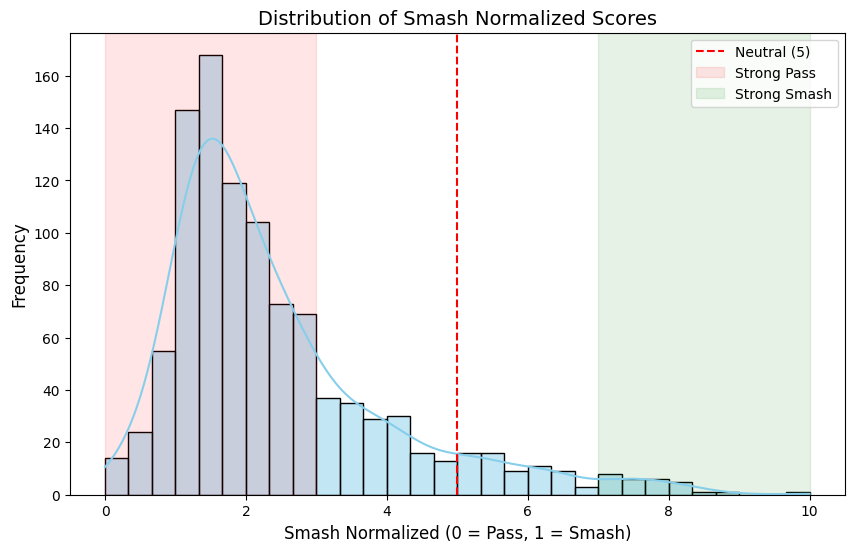

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [135]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Raw arrays from your DataFrame
paths = df['filename'].values  # Image paths
labels = df['Smash Normalized'].values  

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=42
)


def process_path(file_path, label):
    full_path = tf.strings.join(["images/", file_path])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label


def augment_high_scores(image, label):
    def apply_augmentations(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return tf.clip_by_value(img, 0, 1)
    
    return tf.cond(
        label > 0.7,  # Use normalized threshold (0-1)
        lambda: (apply_augmentations(image), label),
        lambda: (image, label)
    )


# Create datasets with augmentation
def create_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_high_scores, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)


# Create training and validation datasets
train_ds = create_dataset(train_paths, train_labels, augment=True)
val_ds = create_dataset(val_paths, val_labels)

# Model definition
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)  # Linear activation for regression
])

# Custom weighted loss
def weighted_mse(y_true, y_pred):
    # Apply quadratic weighting (bigger difference gets higher weight)
    weights = (y_true - 5)**2 + 1  # Change 5 to adjust threshold for higher weight
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


model.compile(
    optimizer='adam',
    loss=weighted_mse,
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
)

# Training with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    # ]
)
# Train the model



Epoch 1/25
26/26 [==============================] - 16s 526ms/step - loss: 161.2774 - mae: 1.8059 - root_mean_squared_error: 2.2854 - val_loss: 75.6891 - val_mae: 1.4916 - val_root_mean_squared_error: 1.7373
Epoch 2/25
26/26 [==============================] - 14s 511ms/step - loss: 84.5745 - mae: 1.3373 - root_mean_squared_error: 1.6565 - val_loss: 73.4727 - val_mae: 1.5261 - val_root_mean_squared_error: 1.8148
Epoch 3/25
26/26 [==============================] - 13s 492ms/step - loss: 76.7470 - mae: 1.2744 - root_mean_squared_error: 1.5946 - val_loss: 64.6046 - val_mae: 1.0294 - val_root_mean_squared_error: 1.3323
Epoch 4/25
26/26 [==============================] - 15s 566ms/step - loss: 66.7279 - mae: 1.1829 - root_mean_squared_error: 1.4724 - val_loss: 62.0555 - val_mae: 1.0747 - val_root_mean_squared_error: 1.3668
Epoch 5/25
26/26 [==============================] - 14s 511ms/step - loss: 58.7247 - mae: 1.1465 - root_mean_squared_error: 1.4462 - val_loss: 63.8564 - val_mae: 1.2859 - 

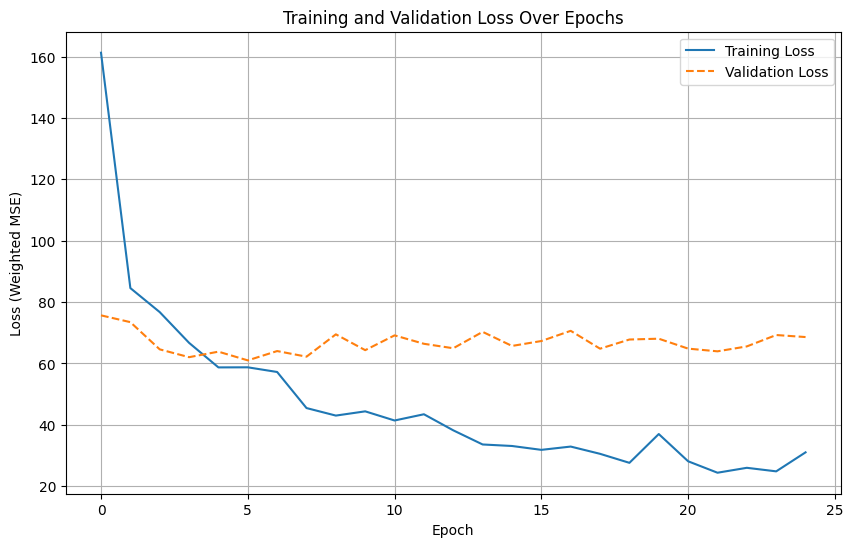

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss (Weighted MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()